## ASTR630 - MCMC analysis

@oanavesa 
05/11/2020

I worked with Farhan on this.

## 1. Write down the expression for the a posteriori probability distribution function. Discuss what you adopt for priors on the parameters.



The a posteriori probaility distribution function can be expressed as the $p(\mathbf{M} \,|\, \mathbf{D})$, or the resulting probability of the model in

$$p(\mathbf{M} \,|\, \mathbf{D}) = \frac{p(\mathbf{D} \,|\, \mathbf{M}) \, p(\mathbf{M})}{p(\mathbf{D})}$$

where $p(\mathbf{D} \,|\, \mathbf{M})$ is the likelihood of observing the data given this specific model, $p(\mathbf{D})$ is the evidence, and $p(\mathbf{M})$ is the prior.

I am adopting a Jeffreys prior (flat prior) for the parameters. This is to ensure the parameter values does not change drastically due to other changing variable values. In the past, we have only ever worked with one Gaussian, so the prior was 1/$\sigma$. However, now that there are three combined Guassians, I decided to combine my prior as $(1/\sigma_1 + 1/\sigma_2 + 1/\sigma_3)$ in order to account for all three Gaussians.

In [1]:
#import packages:

import numpy as np
import matplotlib.pyplot as plt
import corner
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.stats import chi2
c_kms = 3e5 #speed of light (km/s)

In [2]:
# importing AGN at R3000 file
agn_file = fits.open('AGN_R3000.fits')
waves_agn = agn_file[0].header['CRVAL1']+agn_file[0].header['CDELT1']*np.arange(agn_file[0].header['NAXIS1'])
flux_agn = agn_file[0].data

# errors
rn = 3
sig_agn = np.sqrt(flux_agn + rn**2)


In [3]:
def gaussian_agn(x,par1,par2,par3,par4,par5,par6):
    """ Return normalized combined Gaussian function here for three peaks.
    
    Input:
    x = wavelength array
    par1 = amplitude of 1st wave
    par2 = amplitude of 2nd wave
    par3 = amplitude of 3rd wave
    par4 = width of 1st wave
    par5 = width of 2nd wave
    par6 = width of 3rd wave
    
    Output:
    np.min(flux_agn)+G1+G2+G3 = the added gaussian functions + continuum
    """
    

    G1 = par1*np.exp((-(x-wc1)**2)/(2*par4**2))
    G2 = par2*np.exp((-(x-wc2)**2)/(2*par5**2)) 
    G3 = par3*np.exp((-(x-wc3)**2)/(2*par6**2)) 
    
    return  np.min(flux_agn)+G1+G2+G3

# center of lines
wc1,wc2,wc3 = 6548.3,6562.8,6583.41

# intial guesses
init = np.array([500,700,1000,1,7,1]) #initial guesses

low_bounds = [10,10,10,0.1,0.1,0.1]
high_bounds = [600,1000,1000,19,20,19]

derived_params,derived_params_error = curve_fit(gaussian_agn,waves_agn,flux_agn,p0=init,bounds=(low_bounds,high_bounds),sigma=sig_agn)

print(derived_params)

[215.45701094 690.4980904  718.22186116   1.47942823  12.91614796
   1.61732382]


In [4]:
def gaussian_mcmc(par):
    ''' This function is the  log likelihood for a gaussian.
    
    Input:
    par = parameters
    
    Output:
    log likelihood of a gaussian
    '''
    A1,A2,A3,s1,s2,s3 = par
    
    fw = gaussian_agn(waves_agn,A1,A2,A3,s1,s2,s3)
    sm = ((flux_agn-fw)/sig_agn)**2
    
    return -0.5*np.sum(sm)

In [5]:
def prior(par):
    
    """ This function gives the priors
    
    """
    A1,A2,A3,s1,s2,s3 = par
    
    return (1/s1) + (1/s2) + (1/s3) # add calculation of prior here


def guassian_post(theta):
    """This function computes the log-posterior probability"""
    return prior(theta) + gaussian_mcmc(theta)

In [6]:
def metropolis_step(lnpost_function, theta_t, lnpost_t, step_cov):
        
    #new position:
    q = np.random.multivariate_normal(theta_t, step_cov)
    
    #probability of new position:
    p1 = lnpost_function(q)
        
    # evaluate probability ratio of new point to old point:
    alpha = np.exp(p1-lnpost_t)
    
    r = np.random.rand()

    # Metropolis Hastings:
    
    if not ((alpha > 1) or (r < alpha)):
    
        q,p1 = theta_t, lnpost_t
    
    return q,p1
    

## 2. Run MCMC to derive the posterior PDF. You can use a canned MCMC routine or write your own. Present the chains for the parameters and the acceptance fraction. Describe how you handled starting guesses and the burn-in.



The starting guesses were initially just based off of the appearance of the plotted AGN spectrum. By evaluating the size and shape of the lines, I was able to formulate gueeses for each line's amplitudes and widths. Then, after running the non-linear least squares fitting code, I checked to see if the fit was alright. I altered my intial guess based off of that. After running the MCMC code, I adjusted the intial guesses if they were off to be similar to what it seemed the MCMC code was converging on.

As for the burn in value, at first, it was at 1000; however, I quickly realized that I needed to increase the burn in to obtain a more accurate fit for the parameters. Without increasing the burn in, the MCMC chains were not as "grassy" as they are now; they resembled mountains. So, the burn in was increased slightly to 5000. This discarded a bunch of initial values that were not that close to the true AGN parameters and allowed the chain more time to converge.

In [9]:
# Using the algorithm from the MCMC tutorial to check if everything
# was implemented correctly

lptest = lambda x: -0.5 * np.sum(x**2)
th = np.array([0.0])
lp = 0.0
chain=[]
for _ in range(10000) :
    th, lp = metropolis_step(lptest, th, lp, [[0.3]])
    chain.append(th)
chain=np.array(chain)
#chain = np.array([th for th, lp in (metropolis_step(lptest, th, lp, [[0.3]])
#                                    for _ in range(10000))])
if np.abs(np.mean(chain)) > 0.1 or np.abs(np.std(chain) - 1.0) > 0.1:
    raise ValueError("It looks like your implementation is wrong!")
print("☺︎")

☺︎


In [10]:
# proposal covariance
# 0-2: ampltiudes of line; 3-5: widths of lines
step = np.diag([40, 40, 40, 1e-3, 1e-3, 1e-3])

# Edit this line to choose the number of steps you want to take:
nstep = 80000

# Edit this line to set the number steps to discard as burn-in.
nburn = 5000

# You shouldn't need to change any of the lines below here.
p0 = np.array([200,700,700,1,10,1])
lp0 = guassian_post(p0)
chain = np.empty((nstep, len(p0)))
for i in range(len(chain)):
    p0, lp0 = metropolis_step(guassian_post, p0, lp0, step)
    chain[i] = p0
    
# Compute the acceptance fraction.
acc = float(np.any(np.diff(chain, axis=0), axis=1).sum()) / (len(chain)-1)
print("The acceptance fraction was: {0:.3f}".format(acc))


The acceptance fraction was: 0.467


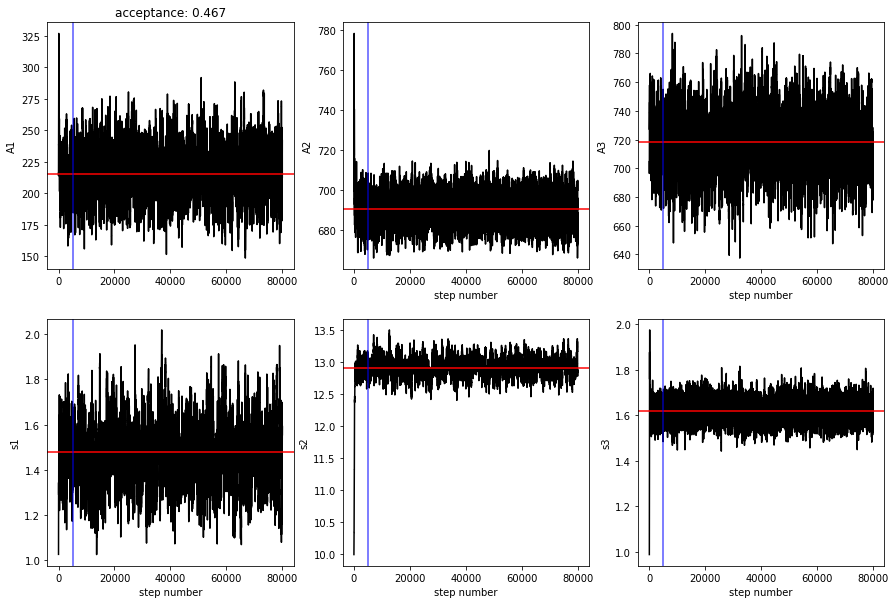

In [11]:
# Plot the traces.
fig,axes = plt.subplots(2,3,figsize=(15,10))

axes = axes.ravel()

axes[0].plot(chain[:, 0], "k")
axes[0].axhline(derived_params[0], color="red", lw=1.5)
axes[0].set_ylabel("A1")
axes[0].axvline(nburn, color="blue", alpha=0.5, lw=2)

axes[1].plot(chain[:, 1], "k")
axes[1].axhline(derived_params[1], color="red", lw=1.5)
axes[1].set_ylabel("A2")
axes[1].axvline(nburn, color="blue", alpha=0.5, lw=2)
axes[1].set_xlabel("step number")

axes[2].plot(chain[:, 2], "k")
axes[2].set_ylabel("A3")
axes[2].axhline(derived_params[2], color="red", lw=1.5)
axes[2].axvline(nburn, color="blue", alpha=0.5, lw=2)
axes[2].set_xlabel("step number")

axes[3].plot(chain[:, 3], "k")
axes[3].set_ylabel("s1")
axes[3].axhline(derived_params[3], color="red", lw=1.5)
axes[3].axvline(nburn, color="blue", alpha=0.5, lw=2)
axes[3].set_xlabel("step number")

axes[4].plot(chain[:, 4], "k")
axes[4].set_ylabel("s2")
axes[4].axhline(derived_params[4], color="red", lw=1.5)
axes[4].axvline(nburn, color="blue", alpha=0.5, lw=2)
axes[4].set_xlabel("step number")

axes[5].plot(chain[:, 5], "k")
axes[5].set_ylabel("s3")
axes[5].axhline(derived_params[5], color="red", lw=1.5)
axes[5].axvline(nburn, color="blue", alpha=0.5, lw=2)
axes[5].set_xlabel("step number")

axes[0].set_title("acceptance: {0:.3f}".format(acc))
plt.show()

## 3. Show corner plots of the parameter space and discuss whether any correlations that you might see are expected.

## 4. Present the maximum a posteriori parameter values, and also the maximum of the marginalized probability distribution for each parameter. Present the credible regions for each parameter.

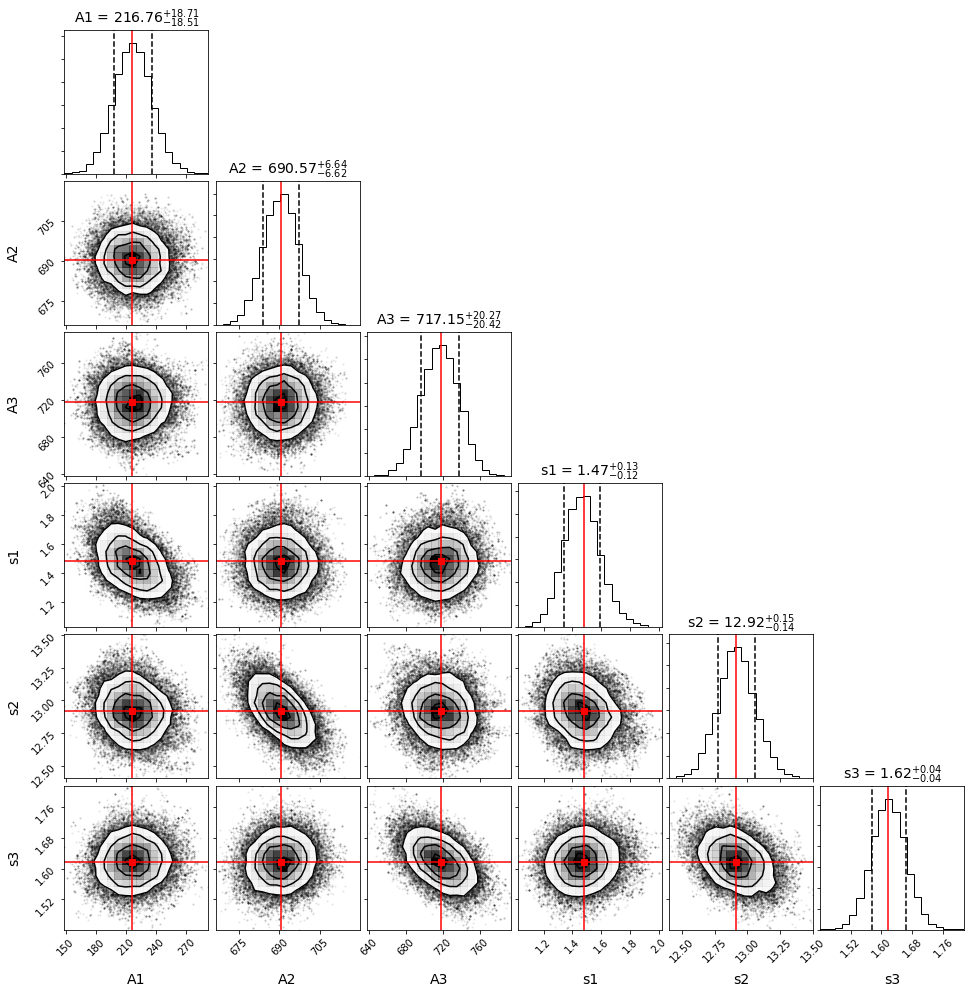

In [12]:
#corner plots

cplot = corner.corner(chain[nburn:, :], labels=["A1", "A2","A3","s1","s2","s3"],truths=derived_params,show_titles=True,quantiles=[.16,.84],title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 14}, truth_color='red')
plt.savefig('corner_AGNR3000.png',dpi=150)

Correlations:

I know that the two [NII] lines (s1 and s3) are supposed to have the same velocity width and that the velocity widths for the three lines falls under a 1:3 ratio. The corner plots reflect this. If you look at s1 and s3, you can see that the samples are almost perfectly circular indicating symmetry around the true value -- indicating that the values are similar. On the other hand, if you looked at s2 and s3, you can see that the distribution is now more elliptical indicating that those values are different and that the s2 value is larger. I really would not expect there to be much of a correlation between the amplitude and velocity widths for each line, and the corner plots reflect this.


In other words, the more correlated values are, the distribution between them is more circular. The less correlated the values are, the more elliptical the distribution appears.

The maxmimum a posteriori parameter values are given at the top of the histograms:
A1 = 216.76, A2 = 690.57, A3 = 717.15, s1 = 1.47, s2 = 12.92, and s3 = 1.62.

The maximum marginalized probability distributions are the histograms seen above.

The black dashed lines are the 1-$\sigma$ credible region.